In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

## Set-up

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [2]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 

    ax.imshow(img)

## Example image

In [6]:
import os
os.chdir('..')
image = Image.open("notebooks/videos/cells/00000.jpg")
image = np.array(image.convert("RGB"))

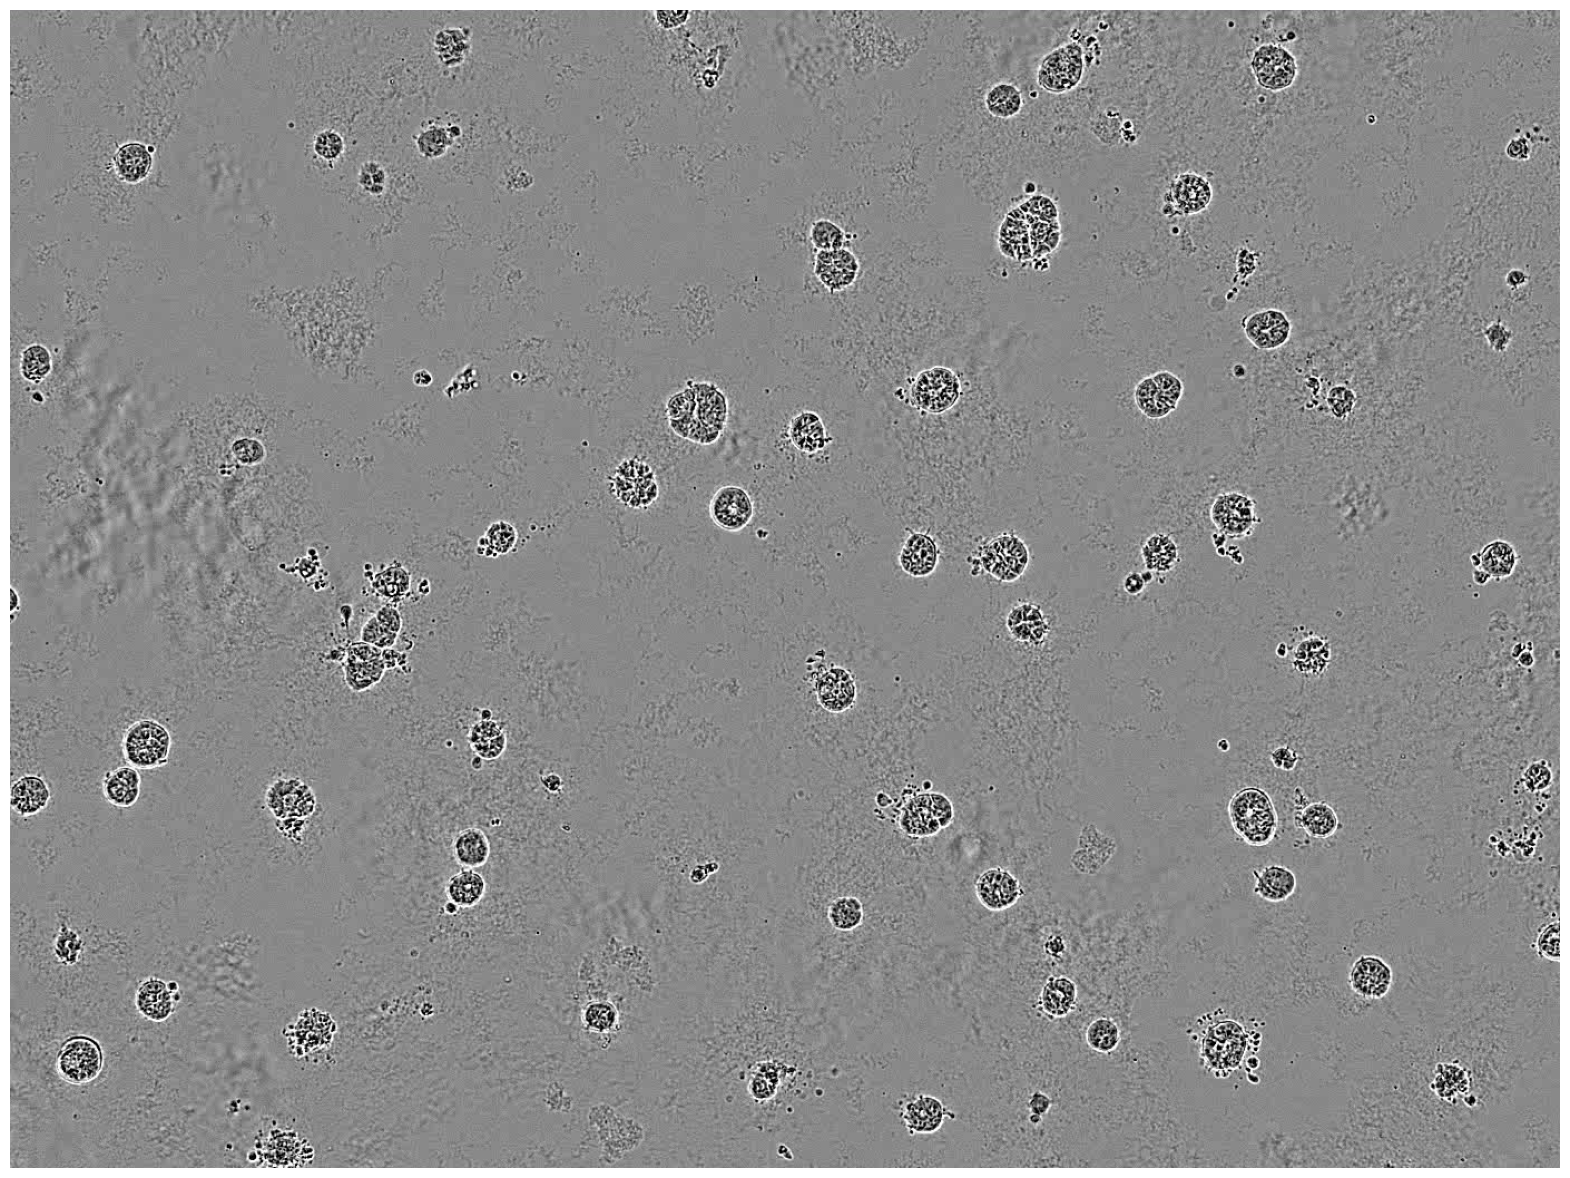

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [8]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "checkpoint/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device ='cuda', apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

/rds/general/user/abs121/home/UROP_2024/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


To generate masks, just run `generate` on an image.

In [12]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [19]:
masks[0]

{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'area': 1447276,
 'bbox': [0.0, 0.0, 1391.0, 1039.0],
 'predicted_iou': 0.99609375,
 'point_coords': [[1326.75, 16.25]],
 'stability_score': 0.985273003578186,
 'crop_box': [0.0, 0.0, 1392.0, 1040.0]}

Show all the masks overlayed on the image.

TypeError: string indices must be integers

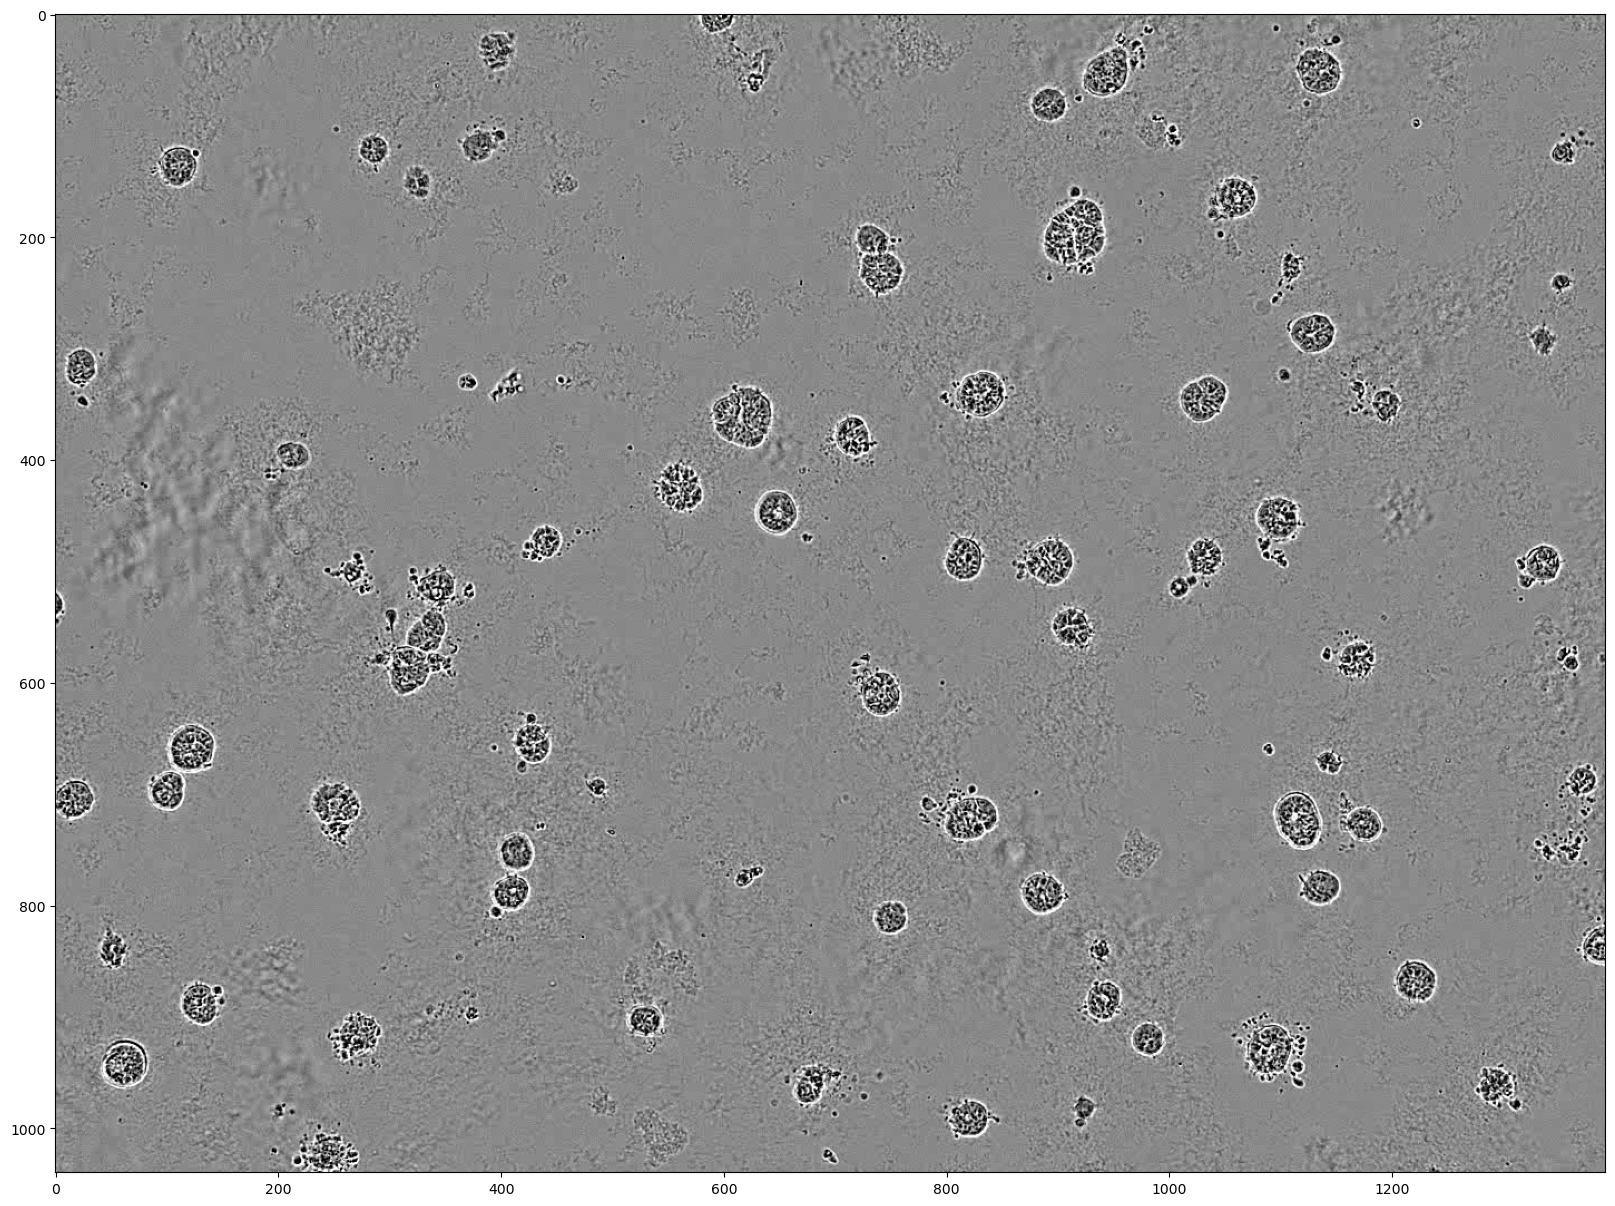

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [20]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [21]:
masks2 = mask_generator_2.generate(image)


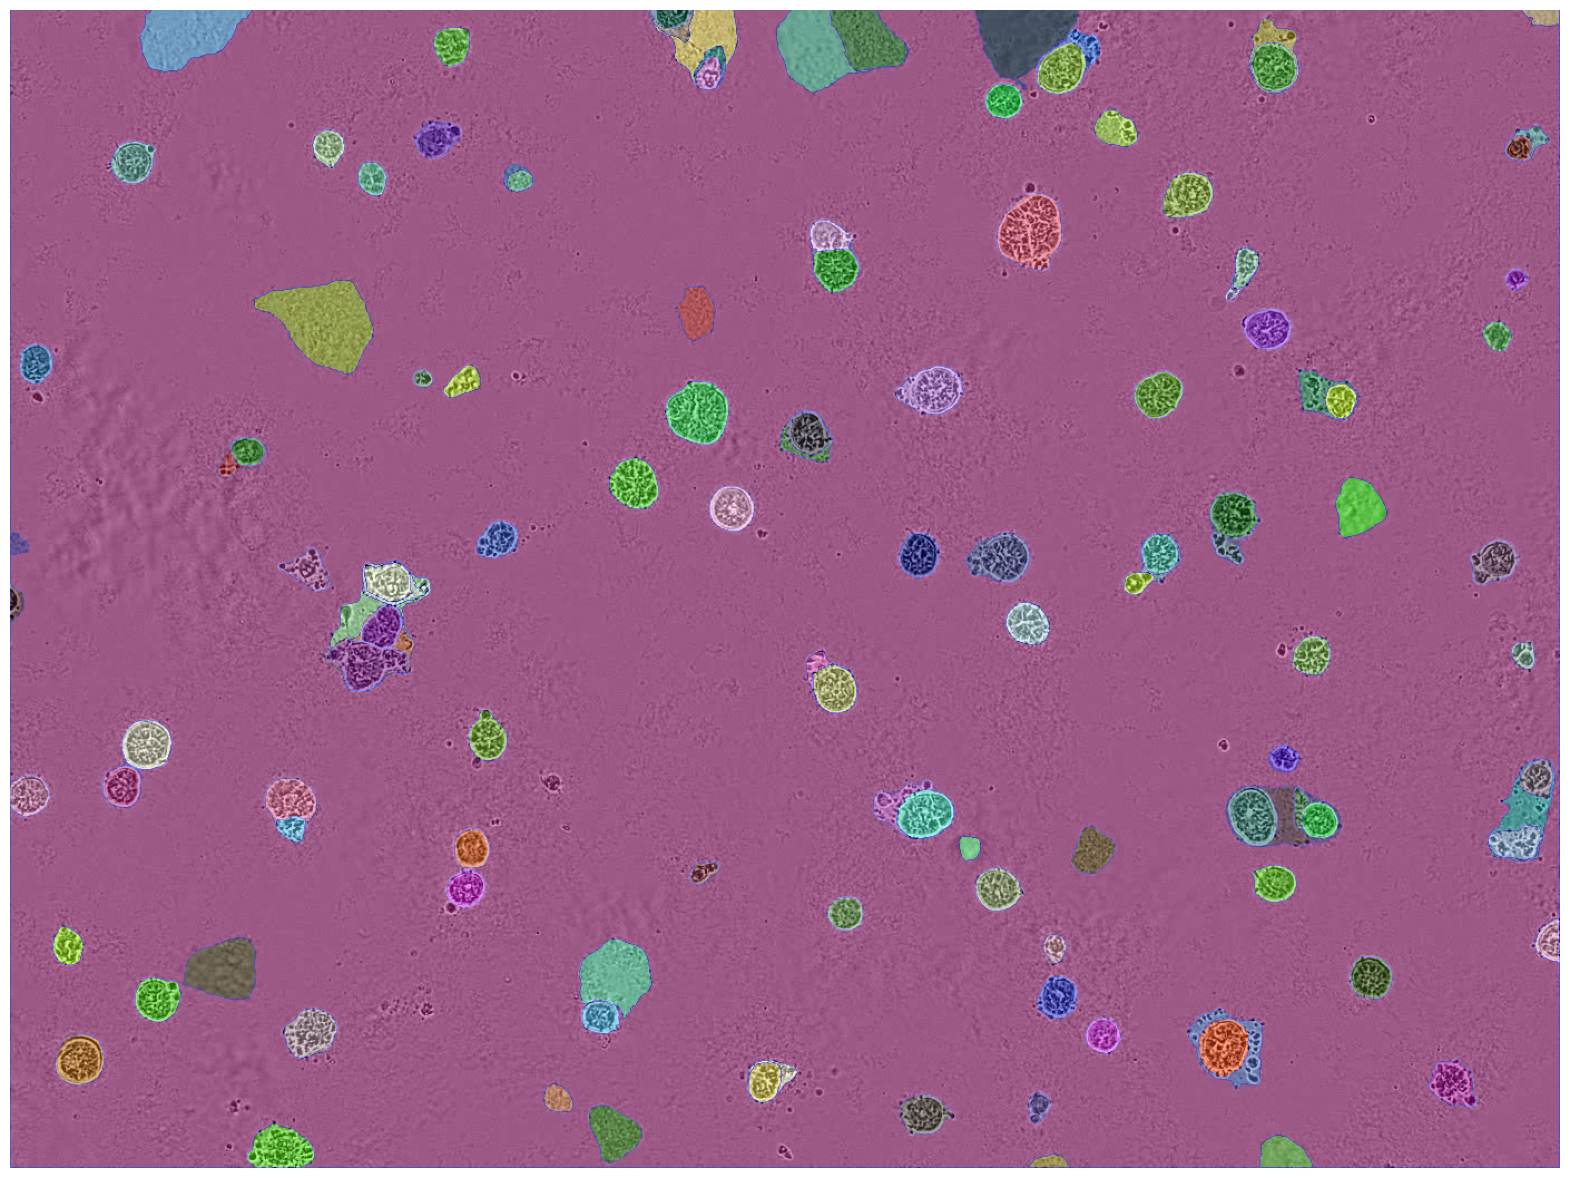

In [22]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [1]:
import os
from PIL import Image
import numpy as np
import torch
os.chdir('..')
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Setup
video_path = "notebooks/videos/cells"
sam2_checkpoint = "checkpoint/sam2_hiera_tiny.pt"
model_cfg = "sam2_hiera_t.yaml"
device = "cuda"

# Auto-masking of first frame (from automatic mask generation notebook)
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)
first_frame_path = os.path.join(video_path, os.listdir(video_path)[0])
first_frame = Image.open(first_frame_path)
first_frame = np.array(first_frame.convert("RGB"))
mask_generator = SAM2AutomaticMaskGenerator(sam2)
auto_masks = mask_generator.generate(first_frame)
print("Number of auto-masks:", len(auto_masks))



/rds/general/user/abs121/home/UROP_2024/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


Number of auto-masks: 62


In [2]:
# Add every 'auto-mask' as it's own prompt for video tracking
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)
inference_state = predictor.init_state(video_path=video_path)
dtype = next(predictor.parameters()).dtype
lowres_side_length = predictor.image_size // 4
for mask_idx, mask_result in enumerate(auto_masks):

    # Get mask into form expected by the model
    mask_tensor = torch.tensor(mask_result["segmentation"], dtype=dtype, device=device)
    lowres_mask = torch.nn.functional.interpolate(
        mask_tensor.unsqueeze(0).unsqueeze(0),
        size=(lowres_side_length, lowres_side_length),
        mode="bilinear",
        align_corners=False,
    ).squeeze()

    # Add each mask as it's own 'object' to segment
    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=0,
        obj_id=mask_idx,
        mask=lowres_mask,
    )
    

# # Do video segmentation (same as video segmentation notebook)
# video_segments = {}
# for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
#     video_segments[out_frame_idx] = {
#         out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)
#     }

frame loading (JPEG): 100%|██████████| 162/162 [00:09<00:00, 16.43it/s]


In [27]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
#     print(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [5]:
import matplotlib.pyplot as plt

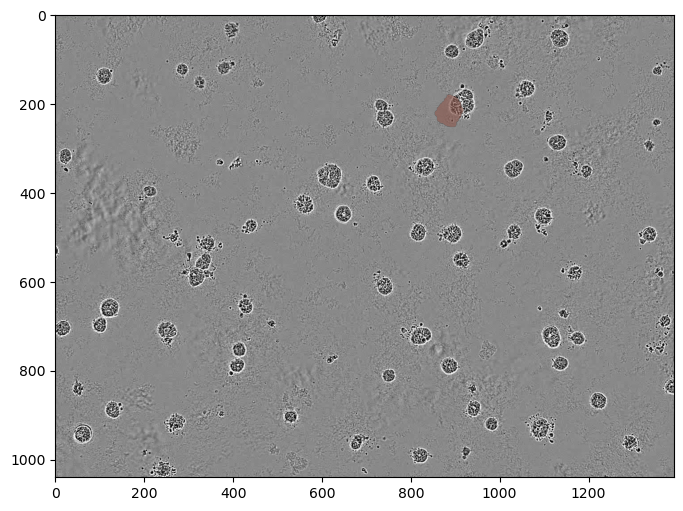

In [29]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_path)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
# plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_path, frame_names[0])))
# show_points(points, labels, plt.gca())
i=5
show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[i])

In [21]:
out_obj_ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61]